# Companies House Example 💼

Install and import all dependencies.

In [7]:
%pip install requests
%pip install pyvis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

## Visualise graph with vis.draw() method in Raphtory.
### vis.draw() requires a Raphtory graph. 

1. If you would like custom node images, you can add an image url as a property when adding a vertex onto the Raphtory graph. e.g. properties = {"image": "your-image-url.png"}. Then add the property name to variable `node_image` when calling vis.draw(). You will also need to set the variable `shape` as "image".

2. To change the thickness of an edge based off edge weight, make sure you add your edge weights as a property when adding edges to your Raphtory graph. e.g. properties = {"weight": 1}. You will also need to set the variable `edge_weight` to the your property name when calling vis.draw().

3. To add labels on your edges which can be seen when hovering over the edges with your cursor, you will need to add your label text as a property when adding your edges. You will also need to set the variable `edge_label` when you call vis.draw().

nx.html


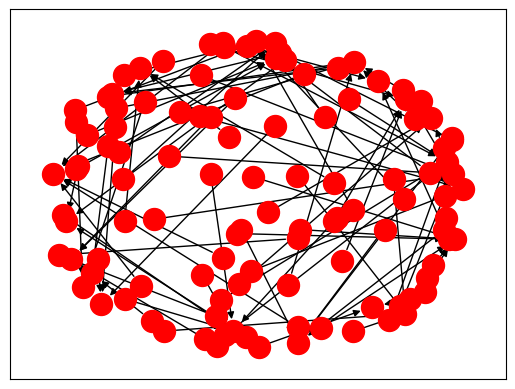

In [9]:
from raphtory import vis
from raphtory import Graph
import requests
from contextlib import closing
import csv
import codecs

url = "https://raw.githubusercontent.com/Raphtory/Data/main/companies_house_nhs_data.csv"
g = Graph()
with closing(requests.get(url, stream=True)) as r:
    reader = csv.reader(codecs.iterdecode(r.iter_lines(), 'utf-8'), delimiter=',')
    next(reader)
    for row in reader:
        src = row[1].strip()
        dst = row[7].strip()
        company = row[2].replace("'", "")
        notified_on = row[0]
        share = row[3]
        title = f'Ownership: {share}%, Notified On: {notified_on}'

        g.add_vertex(1, src, properties={"image": "https://www.seekpng.com/png/small/846-8465978_critres-de-choix-pour-la-solution-de-cration.png"})
        g.add_vertex(1, dst, properties={"image": "https://www.seekpng.com/png/small/846-8465978_critres-de-choix-pour-la-solution-de-cration.png"})
        g.add_vertex(1, company, properties={"image": "https://cdn-icons-png.flaticon.com/512/2083/2083417.png"})
        g.add_edge(1, src, company, properties={"title": title, "weight": share})
        g.add_edge(1, dst, company, properties={"title": title, "weight": share})

vis.to_networkx(graph=g, k=0.8, node_size=250, node_color="red")
vis.to_pyvis(graph=g, edge_color='#F6E1D3', edge_weight="weight", shape="image", edge_label="title", node_image="image")  